# U-Net Brain Tumor Segmentation

In [1]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib
import time

# Data augmentation
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, ElasticTransform, Rotate, RandomScale, GridDistortion, OpticalDistortion, OneOf
)

# Custom scripts
import datagen
import ensemble_functions
import model as unet_model_script

# Reload lib contents
importlib.reload(datagen)
importlib.reload(unet_model_script)
importlib.reload(ensemble_functions)

Using TensorFlow backend.


<module 'ensemble_functions' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\ensemble_functions.py'>

##  Hyperparemeters

In [2]:
train_patients = 239 + 69
valid_HGG_patients = 20
slices_from_patient = 7

slices_from = 60
slices_to = 100

image_size = 240
channels = 4
learning_rate = 1e-4
epochs = 40
batch_size = 7


### U-Net model parameters

Configuration dict.

In [3]:
conf = {
    "last_layer_activation": "sigmoid",
    "dropout": 0.05,
    "batch_norm": False
}

In [4]:
training_model_conf = {
    "optimizer": keras.optimizers.Adam(learning_rate=learning_rate),
    "loss": "binary_crossentropy",
    "metrics": ["accuracy"]
}

## Dataset

In [5]:
st = time.time()
x_train, y_train = datagen.get_dataset(batch_size,
                                        slices_from, slices_to,
                                        file_path='../dataset/', 
                                        mode='training', 
                                        tumor_region=None,
                                        glioma_type=['HGG', 'LGG'], 
                                        slices_w_tumor_only=100,
                                        slices_w_less_brain=None,
                                        image_size=image_size,
                                        train_HGG_patients=train_patients) #
print("Finished in", time.time() - st)

training data with the shape: (2114, 4, 240, 240) (2114, 1, 240, 240)
Finished in 369.1861033439636


In [6]:
# x_valid, y_valid = datagen.get_dataset(batch_size, 
#                                        slices_from, slices_to,
#                                         file_path='../dataset/', 
#                                         mode='validation', 
#                                        tumor_region=3,
#                                         glioma_type=['HGG', 'LGG'], 
#                                         slices_w_tumor_only=False,
#                                         slices_w_less_brain=100,
#                                         image_size=image_size,
#                                         train_HGG_patients=valid_HGG_patients)

10


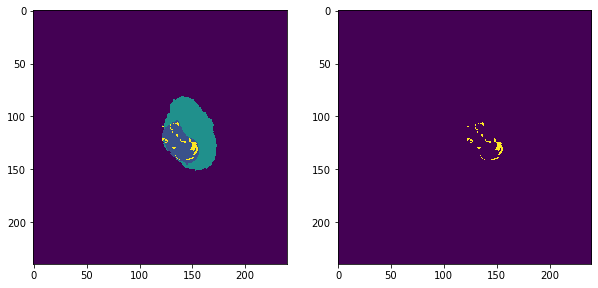

In [6]:
i = random.randint(0, 41)
i = 10
print(i)

f, axarr = plt.subplots(1,2, figsize=(10,10))
axarr[0].imshow(y_train[i][0])
axarr[1].imshow(datagen.convert_labels_eval(y_train, "enhancing", image_size)[i][0])


# axarr[0].imshow(x_train[i][0])
# axarr[1].imshow(x_train[i][1])
# axarr[2].imshow(x_train[i][2])
# axarr[3].imshow(x_train[i][3])
# axarr[4].imshow(y_train[i][0])

## Data augmentation

In [7]:
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
#     Rotate(limit=90, p=0.99),
#     RandomGamma(gamma_limit=(80, 120), p=0.25),
#     RandomScale(scale_limit=0.1, interpolation=cv2.INTER_NEAREST, p=0.25),
#     ElasticTransform(alpha=1, p=0.5),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#     ], p=0.2),
    OpticalDistortion(p=0.5),
    GridDistortion(p=0.5),
])

## Callbacks

In [8]:
class NegativeLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        if logs.get('loss') < 0:
            print("\nEarly stopping for negative loss ({}) at batch {}.".format(logs.get('loss'), batch))
            self.model.stop_training = True

callbacks = [
    NegativeLoss(),
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='accuracy', 
                                            min_delta=0.0001, 
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True),
    keras.callbacks.callbacks.ReduceLROnPlateau(factor=0.1, 
                                                patience=5, 
                                                min_lr=0.00001, 
                                                verbose=1),
#     keras.callbacks.TensorBoard(log_dir="../logs/{}".format(time.time()))
]

# Ensemble training

In [9]:
models = {}
tumor_regions = ["whole", "core", "enhancing"]
cv_x_train = np.array_split(x_train, 3)
cv_y_train = np.array_split(y_train, 3)

time_start = time.time()

# Cross validation
for k in range(1, 2):

    x_v, y_v = cv_x_train[k - 1], cv_y_train[k - 1]
    if k-1 == 0:
        x_t, y_t = np.concatenate((cv_x_train[1], cv_x_train[2])), np.concatenate((cv_y_train[1], cv_y_train[2]))
    elif k-1 == 1:
        x_t, y_t = np.concatenate((cv_x_train[0], cv_x_train[2])), np.concatenate((cv_y_train[0], cv_y_train[2]))
    else:
        x_t, y_t =  np.concatenate((cv_x_train[0], cv_x_train[1])), np.concatenate((cv_y_train[0], cv_y_train[1]))
    
    print(x_t.shape, x_v.shape)
    for tumor_region in [tumor_regions[1]]:

        print("Training U-Net {}".format(tumor_region))

        # Get and compile model
        models[tumor_region] = unet_model_script.UNet(channels, image_size, conf=conf)
        models[tumor_region].compile(**training_model_conf)

        # Convert mask labels to binary
        train_masks = datagen.convert_labels_eval(y_t, tumor_region, image_size)
        valid_masks = datagen.convert_labels_eval(y_v, tumor_region, image_size)

        # Init datagen w augmentation
        train_gen = datagen.AugmentationDatagen(x_t, train_masks, batch_size, AUGMENTATIONS)

        # Start training
        models["hist_{}".format(tumor_region)] = models[tumor_region].fit(train_gen, 
                                                                          validation_data=(x_v, valid_masks), 
                                                                          epochs=epochs, 
                                                                          shuffle=True, 
                                                                          callbacks=callbacks)
        
        models[tumor_region].save("../models/base_d_5_new/{}_ensemble_{}.h5".format(k, tumor_region))

print("Training time: {}".format(time.time()-time_start))

(1409, 4, 240, 240) (705, 4, 240, 240)
Training U-Net core
Epoch 1/40
202/202 [==============================] - 93s 459ms/step - loss: 0.0406 - accuracy: 0.9905 - val_loss: 0.0165 - val_accuracy: 0.9939
Epoch 2/40
202/202 [==============================] - 85s 419ms/step - loss: 0.0333 - accuracy: 0.9884 - val_loss: 0.0224 - val_accuracy: 0.9912
Epoch 3/40
202/202 [==============================] - 85s 419ms/step - loss: 0.0316 - accuracy: 0.9889 - val_loss: 0.0151 - val_accuracy: 0.9944
Epoch 4/40
202/202 [==============================] - 87s 433ms/step - loss: 0.0291 - accuracy: 0.9897 - val_loss: 0.0186 - val_accuracy: 0.9939
Epoch 5/40
202/202 [==============================] - 87s 431ms/step - loss: 0.0275 - accuracy: 0.9897 - val_loss: 0.0146 - val_accuracy: 0.9941
Epoch 6/40
202/202 [==============================] - 85s 420ms/step - loss: 0.0245 - accuracy: 0.9904 - val_loss: 0.0140 - val_accuracy: 0.9942
Epoch 7/40
202/202 [==============================] - 85s 420ms/step - 

### Results

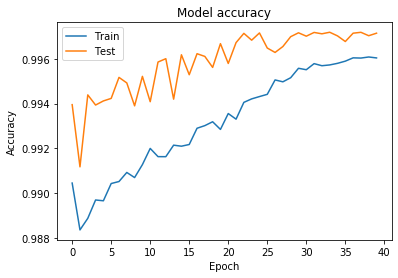

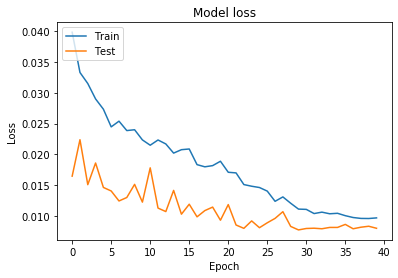

In [11]:
tumor_region = "core"

# Plot training & validation accuracy values
plt.plot(models["hist_{}".format(tumor_region)].history['accuracy'])
plt.plot(models["hist_{}".format(tumor_region)].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(models["hist_{}".format(tumor_region)].history['loss'])
plt.plot(models["hist_{}".format(tumor_region)].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
p = models[1].predict(x_train, verbose=1)

In [ ]:
y_m = datagen.convert_labels(y_train, tumor_region, image_size)

In [ ]:
i = random.randint(0,2000)

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(p[i][0])
axarr[1].imshow(y_m[i][0])

In [ ]:
# i = random.randint(0, 50)
# i = 3
# pred = models[1].predict(np.array([x_valid[i]]), verbose=1)
# f, axarr = plt.subplots(1,2, figsize=(10,10))
# axarr[0].imshow(y_valid[i][0])
# axarr[1].imshow(pred[0][0])